# Comparison Reinforcement Learning vs. CFE Approach

In this notebook, the results of using Reinforcement Learning for controlling Burgers' Equation are compared to a supervised control force estimator approach using a differentiable physics loss function, which was proposed by Holl et al. [2020](https://ge.in.tum.de/publications/2020-iclr-holl). Both methods use the differentiable PDE solver [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow).

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../../'); sys.path.append('../envs'); sys.path.append('../../PDE-Control/PhiFlow'); sys.path.append('../../PDE-Control/src')
from phi.flow import *
import burgers_plots as bplt
import matplotlib.pyplot as plt
from burgers_util import GaussianClash, GaussianForce

## Data generation

At first, we will generate a suite of test scenes on which both methods will be evaluated.

In [4]:
domain = Domain([32], box=box[0:1])
viscosity = 0.003
step_count = 32
dt = 0.03
diffusion_substeps = 1

data_path = 'forced-burgers-clash'
scene_count = 1000
batch_size = 100

train_range = range(200, 1000)
val_range = range(100, 200)
test_range = range(0, 100)

In [28]:
for batch_index in range(scene_count // batch_size):
    scene = Scene.create(data_path, count=batch_size)
    print(scene)
    world = World()
    u0 = BurgersVelocity(
        domain, 
        velocity=GaussianClash(batch_size), 
        viscosity=viscosity, 
        batch_size=batch_size, 
        name='burgers'
    )
    u = world.add(u0, physics=Burgers(diffusion_substeps=diffusion_substeps))
    force = world.add(FieldEffect(GaussianForce(batch_size), ['velocity']))
    scene.write(world.state, frame=0)
    for frame in range(1, step_count + 1):
        world.step(dt=dt)
        scene.write(world.state, frame=frame)

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/phi/data/fluidformat.py:293: UserWarning:

Failed to copy calling script to scene during Scene.create().
Cause: [Errno 2] No such file or directory: '<ipython-input-28-fc5d3be44e31>'



forced-burgers-clash/sim_000000
forced-burgers-clash/sim_000100
forced-burgers-clash/sim_000200
forced-burgers-clash/sim_000300
forced-burgers-clash/sim_000400
forced-burgers-clash/sim_000500
forced-burgers-clash/sim_000600
forced-burgers-clash/sim_000700
forced-burgers-clash/sim_000800
forced-burgers-clash/sim_000900


## CFE Chain Initialization

To classify the results of the reinforcement learning method, they are compared to a supervised control force estimator approach using a differentiable physics loss. This comparison seems fair as both algorithms work by optimizing through trial and error. 

The CFE approach has access to the gradient data provided by the differentiable solver, making it possible to trace the loss over multiple timesteps and enabling the model to better comprehend long term effects of generated forces. 

The reinforcement learning approach on the other hand uses a dedicated value estimator network (critic) to predict the sum of rewards generated from a certain state. These are then used to update a policy network (actor) which, analogously to the control force estimator network, predicts the forces to control the simulation. The reinforcement learning algorithm is not limited by training dataset size, as new training samples are generated on policy. However, this also introduces additional simulation overhead during training. This can increase training duration.

In [2]:
from control.pde.burgers import BurgersPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in 

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWarning:

Passing (type, 1) or '1type' as a synony

In [5]:
cfe_app = ControlTraining(
    step_count,
    BurgersPDE(domain, viscosity, dt),
    datapath=data_path,
    val_range=val_range,
    train_range=train_range,
    trace_to_channel=lambda trace: 'burgers_velocity',
    obs_loss_frames=[],
    trainable_networks=['CFE'],
    sequence_class=StaggeredSequence,
    batch_size=100,
    view_size=20,
    learning_rate=1e-3,
    learning_rate_half_life=1000,
    dt=dt
).prepare()


App created. Scene directory is /home/felix/phi/model/control-training/sim_000065 (INFO), 2021-02-19 12:00:46,116n


Sequence class: <class 'control.sequences.StaggeredSequence'> (INFO), 2021-02-19 12:00:46,474n

Partition length 32 sequence (from 0 to 32) at frame 16
Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/phi/struct/context.py:18: UserWarning:

struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.



Partition length 16 sequence (from 0 to 16) at frame 8


Partition length 8 sequence (from 0 to 8) at frame 4


Partition length 4 sequence (from 0 to 4) at frame 2


Partition length 2 sequence (from 0 to 2) at frame 1


Execute -> 1
Execute -> 2
Partition length 2 sequence (from 2 to 4) at frame 3


Execute -> 3
Execute -> 4
Partition length 4 sequence (from 4 to 8) at frame 6


Partition length 2 sequence (from 4 to 6) at frame 5


Execute -> 5
Execute -> 6
Partition length 2 sequence (from 6 to 8) at frame 7


Execute -> 7
Execute -> 8
Partition length 8 sequence (from 8 to 16) at frame 12


Partition length 4 sequence (from 8 to 12) at frame 10


Partition length 2 sequence (from 8 to 10) at frame 9


Execute -> 9
Execute -> 10
Partition length 2 sequence (from 10 to 12) at frame 11


Execute -> 11
Execute -> 12
Partition length 4 sequence (from 12 to 16) at frame 14


Partition length 2 sequence (from 12 to 14) at frame 13


Execute -> 13
Execute -> 14
Partition length 2 sequence (from 14 to 16) at frame 15


Execute -> 15
Execute -> 16
Partition length 16 sequence (from 16 to 32) at frame 24


Partition length 8 sequence (from 16 to 24) at frame 20


Partition length 4 sequence (from 16 to 20) at frame 18


Partition length 2 sequence (from 16 to 18) at frame 17


Execute -> 17
Execute -> 18
Partition length 2 sequence (from 18 to 20) at frame 19


Execute -> 19
Execute -> 20
Partition length 4 sequence (from 20 to 24) at frame 22


Partition length 2 sequence (from 20 to 22) at frame 21


Execute -> 21
Execute -> 22
Partition length 2 sequence (from 22 to 24) at frame 23


Execute -> 23
Execute -> 24
Partition length 8 sequence (from 24 to 32) at frame 28


Partition length 4 sequence (from 24 to 28) at frame 26


Partition length 2 sequence (from 24 to 26) at frame 25


Execute -> 25
Execute -> 26
Partition length 2 sequence (from 26 to 28) at frame 27


Execute -> 27
Execute -> 28
Partition length 4 sequence (from 28 to 32) at frame 30


Partition length 2 sequence (from 28 to 30) at frame 29


Execute -> 29
Execute -> 30
Partition length 2 sequence (from 30 to 32) at frame 31


Execute -> 31
Execute -> 32
Target loss: Tensor("truediv_1:0", shape=(), dtype=float32) (INFO), 2021-02-19 12:01:28,906n

Force loss: Tensor("Sum_97:0", shape=(), dtype=float32) (INFO), 2021-02-19 12:01:29,792n

Setting up loss (INFO), 2021-02-19 12:01:29,793n


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Preparing data (INFO), 2021-02-19 12:01:53,678n


INFO:tensorflow:Summary name Total Force is illegal; using Total_Force instead.

Initializing variables (INFO), 2021-02-19 12:01:53,703n



/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/phi/struct/context.py:18: UserWarning:

struct.unsafe() is deprecated. Use map() with new_type argument to avoid validation.



Model variables contain 0 total parameters. (INFO), 2021-02-19 12:01:59,741n




Validation (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 277.3628, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 536.7836 (INFO), 2021-02-19 12:02:17,768n



In [31]:
forces = []

for epoch in range(10000):
    cfe_app.progress()
    # Check the amount of forces the current model is producing
    if epoch % 10 == 0:
        # Divide by time delta to retrieve forces from L1 distances
        forces.append(cfe_app.infer_scalars(test_range)['Total Force'] / dt)

Optimization (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 225.0326, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 417.47256 (INFO), 2021-02-18 16:54:16,289n

Validation (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 62.254387, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 234.28264 (INFO), 2021-02-18 16:54:20,860n

Optimization (000050): Learning_Rate: 0.001, Loss_reg_unscaled: 10.119481, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 65.177666 (INFO), 2021-02-18 16:54:38,618n

Validation (000050): Learning_Rate: 0.001, Loss_reg_unscaled: 10.172757, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 64.15814 (INFO), 2021-02-18 16:54:41,762n

Optimization (000100): Learning_Rate: 0.001, Loss_reg_unscaled: 5.7693386, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 54.82039 (INFO), 2021-02-18 16:54:59,368n

Validation (000100): Learning_Rate: 0.001, Loss_reg_unscaled: 5.224224, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 53.1194 (INFO), 2021-02-18 16:55:02,517n

Optimization (000150): Learn

Validation (001250): Learning_Rate: 0.001, Loss_reg_unscaled: 0.9128681, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 24.4268 (INFO), 2021-02-18 17:02:55,319n

Optimization (001300): Learning_Rate: 0.001, Loss_reg_unscaled: 0.9678875, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 24.813475 (INFO), 2021-02-18 17:03:12,784n

Validation (001300): Learning_Rate: 0.001, Loss_reg_unscaled: 0.90299535, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 24.41306 (INFO), 2021-02-18 17:03:15,939n

Optimization (001350): Learning_Rate: 0.001, Loss_reg_unscaled: 0.7839164, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 23.257305 (INFO), 2021-02-18 17:03:33,227n

Validation (001350): Learning_Rate: 0.001, Loss_reg_unscaled: 0.87731034, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 24.034386 (INFO), 2021-02-18 17:03:36,384n

Optimization (001400): Learning_Rate: 0.001, Loss_reg_unscaled: 0.8347265, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 23.718487 (INFO), 2021-02-18 17:03:53,843n

Validation (001400): Le

Optimization (002550): Learning_Rate: 0.001, Loss_reg_unscaled: 0.57085663, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 20.424335 (INFO), 2021-02-18 17:11:45,140n

Validation (002550): Learning_Rate: 0.001, Loss_reg_unscaled: 0.64721406, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 21.348064 (INFO), 2021-02-18 17:11:48,296n

Optimization (002600): Learning_Rate: 0.001, Loss_reg_unscaled: 0.5918962, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 20.586075 (INFO), 2021-02-18 17:12:05,582n

Validation (002600): Learning_Rate: 0.001, Loss_reg_unscaled: 0.6394951, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 21.220793 (INFO), 2021-02-18 17:12:08,766n

Optimization (002650): Learning_Rate: 0.001, Loss_reg_unscaled: 0.5900203, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 20.352163 (INFO), 2021-02-18 17:12:26,125n

Validation (002650): Learning_Rate: 0.001, Loss_reg_unscaled: 0.6368794, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 21.204506 (INFO), 2021-02-18 17:12:29,317n

Optimization (002700

Validation (003800): Learning_Rate: 0.001, Loss_reg_unscaled: 0.53977513, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 20.11451 (INFO), 2021-02-18 17:20:20,028n

Optimization (003850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.4891914, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.122997 (INFO), 2021-02-18 17:20:37,431n

Validation (003850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.5585096, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 20.401514 (INFO), 2021-02-18 17:20:40,570n

Optimization (003900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.54551387, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 20.077232 (INFO), 2021-02-18 17:20:57,740n

Validation (003900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.5319251, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 19.931986 (INFO), 2021-02-18 17:21:00,860n

Optimization (003950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.44299954, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.71643 (INFO), 2021-02-18 17:21:17,992n

Validation (003950): 

Instructions for updating:
Use standard file APIs to delete files with this prefix.


Validation (005000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.4563126, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.712528 (INFO), 2021-02-18 17:28:28,688n

Optimization (005050): Learning_Rate: 0.001, Loss_reg_unscaled: 0.39822912, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.656712 (INFO), 2021-02-18 17:28:45,951n

Validation (005050): Learning_Rate: 0.001, Loss_reg_unscaled: 0.46675456, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.757107 (INFO), 2021-02-18 17:28:49,078n

Optimization (005100): Learning_Rate: 0.001, Loss_reg_unscaled: 0.45413285, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.60112 (INFO), 2021-02-18 17:29:06,235n

Validation (005100): Learning_Rate: 0.001, Loss_reg_unscaled: 0.46503192, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.946365 (INFO), 2021-02-18 17:29:09,373n

Optimization (005150): Learning_Rate: 0.001, Loss_reg_unscaled: 0.38815236, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.869432 (INFO), 2021-02-18 17:29:26,603n

Validation (005150

Optimization (006300): Learning_Rate: 0.001, Loss_reg_unscaled: 0.39873654, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.122435 (INFO), 2021-02-18 17:37:16,956n

Validation (006300): Learning_Rate: 0.001, Loss_reg_unscaled: 0.43222126, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.355679 (INFO), 2021-02-18 17:37:20,112n

Optimization (006350): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3455027, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.059685 (INFO), 2021-02-18 17:37:37,443n

Validation (006350): Learning_Rate: 0.001, Loss_reg_unscaled: 0.4380018, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.29477 (INFO), 2021-02-18 17:37:40,572n

Optimization (006400): Learning_Rate: 0.001, Loss_reg_unscaled: 0.36328155, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.668598 (INFO), 2021-02-18 17:37:58,951n

Validation (006400): Learning_Rate: 0.001, Loss_reg_unscaled: 0.42537373, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.120422 (INFO), 2021-02-18 17:38:02,097n

Optimization (00645

Validation (007550): Learning_Rate: 0.001, Loss_reg_unscaled: 0.41819102, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 18.130241 (INFO), 2021-02-18 17:45:55,317n

Optimization (007600): Learning_Rate: 0.001, Loss_reg_unscaled: 0.31742862, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.716991 (INFO), 2021-02-18 17:46:12,400n

Validation (007600): Learning_Rate: 0.001, Loss_reg_unscaled: 0.3949136, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.54524 (INFO), 2021-02-18 17:46:15,564n

Optimization (007650): Learning_Rate: 0.001, Loss_reg_unscaled: 0.32202405, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.531681 (INFO), 2021-02-18 17:46:32,741n

Validation (007650): Learning_Rate: 0.001, Loss_reg_unscaled: 0.40554565, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.654758 (INFO), 2021-02-18 17:46:35,866n

Optimization (007700): Learning_Rate: 0.001, Loss_reg_unscaled: 0.37204656, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.536455 (INFO), 2021-02-18 17:46:53,094n

Validation (007700

Optimization (008850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.29417378, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 15.905754 (INFO), 2021-02-18 17:54:44,495n

Validation (008850): Learning_Rate: 0.001, Loss_reg_unscaled: 0.38255686, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.316849 (INFO), 2021-02-18 17:54:47,665n

Optimization (008900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.33590704, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.765991 (INFO), 2021-02-18 17:55:04,857n

Validation (008900): Learning_Rate: 0.001, Loss_reg_unscaled: 0.37918836, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.35127 (INFO), 2021-02-18 17:55:08,070n

Optimization (008950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.2998477, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 16.467691 (INFO), 2021-02-18 17:55:25,655n

Validation (008950): Learning_Rate: 0.001, Loss_reg_unscaled: 0.38079202, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 17.415514 (INFO), 2021-02-18 17:55:28,794n

Optimization (0090

In [33]:
cfe_checkpoint = cfe_app.save_model()
cfe_checkpoint

'/home/felix/phi/model/control-training/sim_000064/checkpoint_00010000'

Run the cell below to load a trained model:

In [6]:
cfe_app.load_checkpoints({net: 'cfe-models/bench/checkpoint_00010000' for net in ['OP2', 'OP4', 'OP8', 'OP16', 'OP32']})

Loading OP2 from cfe-models/bench/checkpoint_00010000... (INFO), 2021-02-19 12:02:17,797n

Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from cfe-models/bench/checkpoint_00010000/model.ckpt


INFO:tensorflow:Restoring parameters from cfe-models/bench/checkpoint_00010000/model.ckpt


Loading OP4 from cfe-models/bench/checkpoint_00010000... (INFO), 2021-02-19 12:02:20,810n

INFO:tensorflow:Restoring parameters from cfe-models/bench/checkpoint_00010000/model.ckpt


INFO:tensorflow:Restoring parameters from cfe-models/bench/checkpoint_00010000/model.ckpt


Loading OP8 from cfe-models/bench/checkpoint_00010000... (INFO), 2021-02-19 12:02:23,869n

INFO:tensorflow:Restoring parameters from cfe-models/bench/checkpoint_00010000/model.ckpt


INFO:tensorflow:Restoring parameters from cfe-models/bench/checkpoint_00010000/model.ckpt


Loading OP16 from cfe-models/bench/checkpoint_00010000... (INFO), 2021-02-19 12:02:27,000n

INFO:tensorflow:Restoring parameters from cfe-models/bench/checkpoint_00010000/model.ckpt


INFO:tensorflow:Restoring parameters from cfe-models/bench/checkpoint_00010000/model.ckpt


Loading OP32 from cfe-models/bench/checkpoint_00010000... (INFO), 2021-02-19 12:02:30,123n

INFO:tensorflow:Restoring parameters from cfe-models/bench/checkpoint_00010000/model.ckpt


INFO:tensorflow:Restoring parameters from cfe-models/bench/checkpoint_00010000/model.ckpt


## Reinforcement Learning Initialization

Now we can proceed to loading an existing RL agent. Here, a variation of the training environment is used where a fixed data set can be loaded for the agent to be evaluated on. This gives the advantage that both the CFE and RL method could be tested on the same data. Different agents could be loaded by specifying another directory name at `exp_name`.

In [7]:
from experiment import BurgersEvaluation

In [44]:
rl_app = BurgersEvaluation(
    exp_name='ControlBurgersBench2',
    data_path=data_path,
    data_range=test_range,
)

Loading existing agent from rl-models/ControlBurgersBench2/agent
dict_keys(['num_envs', 'step_count', 'domain', 'dt', 'viscosity', 'diffusion_substeps', 'final_reward_factor', 'exp_name', 'data_path', 'data_range', 'test_mode'])
{'num_envs': 100, 'step_count': 32, 'domain': Domain[valid], 'dt': 0.03, 'viscosity': 0.003, 'diffusion_substeps': 1, 'final_reward_factor': 32, 'exp_name': 'ControlBurgersBench2'}
Using new running mean for reward


## Trajectory Comparison

Now we are set up to perform some face-to-face comparisons between the different methods.

In [9]:
rl_frames, gt_frames, pass_frames, rl_forces = rl_app.infer_all_frames()

cfe_frames = cfe_app.infer_all_frames(test_range)
cfe_frames = [s.burgers.velocity.data for s in cfe_frames]

/home/felix/anaconda3/envs/phiflow/lib/python3.6/site-packages/torch/nn/functional.py:2506: UserWarning:

Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



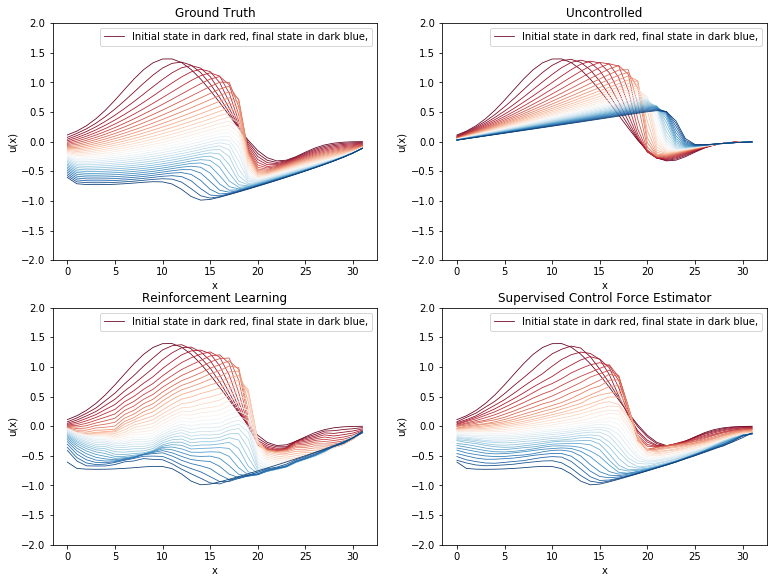

In [75]:
index_in_set = 8
fig, axs = plt.subplots(2, 2, figsize=(12.8, 9.6))

axs[0, 0].set_title('Ground Truth')
axs[0, 1].set_title('Uncontrolled')
axs[1, 0].set_title('Reinforcement Learning')
axs[1, 1].set_title('Supervised Control Force Estimator')

for subplot_idcs in [(0,0), (0,1), (1,0), (1,1)]:
    axs[subplot_idcs].set_ylim(-2, 2)
    axs[subplot_idcs].set_xlabel('x')
    axs[subplot_idcs].set_ylabel('u(x)')
    axs[subplot_idcs].legend(['Initial state in dark red, final state in dark blue,'])
    
def plot_w_label(xy, field): 
    color = bplt.gradient_color(0, step_count+1)
    axs[xy].plot(field[0][index_in_set].squeeze(), color=color, linewidth=0.8, label='Initial state in dark red, final state in dark blue,')
    axs[xy].legend()
    
# Plot the first states and create a legend for each plot
plot_w_label((0, 0), gt_frames)
plot_w_label((0, 1), pass_frames)
plot_w_label((1, 0), rl_frames)
plot_w_label((1, 1), cfe_frames)
    
# Plot the remaining states
for frame in range(1, step_count + 1):
    color = bplt.gradient_color(frame, step_count+1)
    plot = lambda xy, field: axs[xy].plot(field[frame][index_in_set].squeeze(), color=color, linewidth=0.8)
    plot((0,0), gt_frames)
    plot((0,1), pass_frames)
    plot((1,0), rl_frames)
    plot((1,1), cfe_frames)

In [34]:
def infer_forces(frames):
    frames = np.array(frames)
    
    b = Burgers(diffusion_substeps=diffusion_substeps)
    to_state = lambda v: BurgersVelocity(domain, velocity=v, viscosity=viscosity) 
        
    # Simulate all timesteps of all trajectories at once
    # => concatenate all frames in batch dimension
    prv = to_state(frames[:-1].reshape((-1,) + frames.shape[2:]))
    prv_sim = b.step(prv, dt=dt)
    
    forces = (frames[1:] - prv_sim.velocity.data.reshape(step_count, -1, *frames.shape[2:])) / dt
    
    # Sanity check, should be able to reconstruct goal state with forces
    s = to_state(frames[0])
    for i in range(step_count):
        f = forces[i].reshape(s.velocity.data.shape)
        effect = FieldEffect(CenteredGrid(f, box=domain.box), ['velocity'])
        s = b.step(s, dt, (effect,))
    diff = frames[-1] - s.velocity.data
    print('Maximum deviation from target state: %f' % np.abs(diff).max())
    return forces

    
gt_forces = np.abs(infer_forces(gt_frames)).sum(axis=(0, 2)).squeeze()
cfe_forces = np.abs(infer_forces(cfe_frames)).sum(axis=(0, 2)).squeeze()
rl_forces = np.array(rl_forces)

Maximum deviation from target state: 0.000000
Maximum deviation from target state: 0.000000


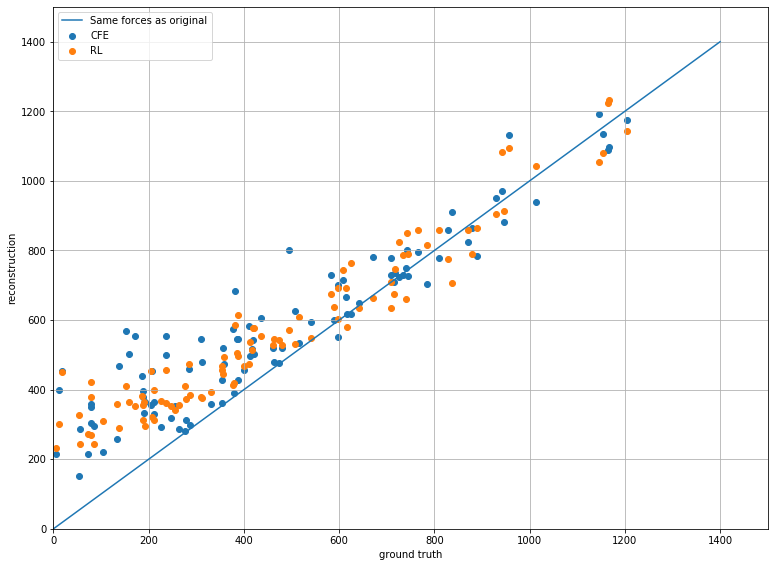

In [38]:
plt.figure(figsize=(12.8, 9.6))
plt.scatter(gt_forces, cfe_forces, label='CFE')
plt.scatter(gt_forces, rl_forces, label='RL')
plt.plot([x * 100 for x in range(15)], [x * 100 for x in range(15)], label='Same forces as original')
plt.xlabel('ground truth')
plt.xlim(0, 1500)
plt.ylim(0, 1500)
plt.ylabel('reconstruction')
plt.grid()
plt.legend()
plt.show()

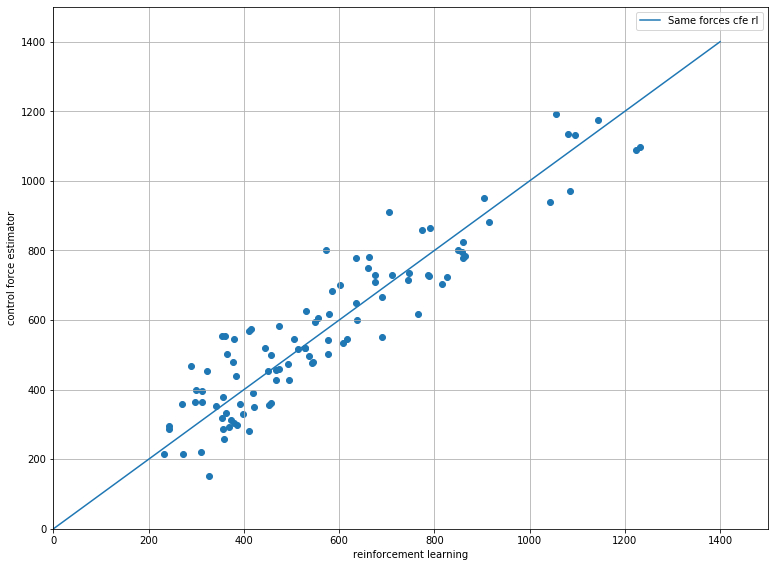

In [42]:
plt.figure(figsize=(12.8, 9.6))
plt.scatter(rl_forces, cfe_forces)
plt.xlabel('reinforcement learning')
plt.ylabel('control force estimator')
plt.plot([x * 100 for x in range(15)], [x * 100 for x in range(15)], label='Same forces cfe rl')
plt.xlim(0, 1500)
plt.ylim(0, 1500)
plt.grid()
plt.legend()
plt.show()

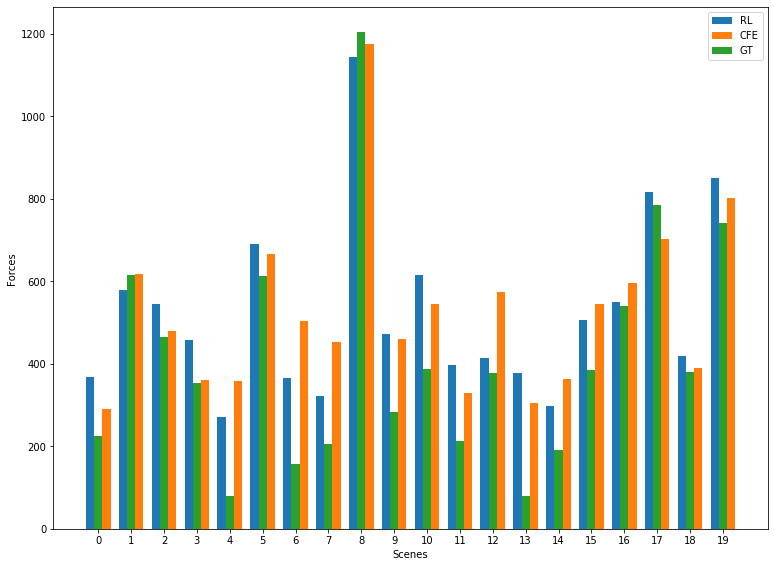

In [77]:
w=0.25
plot_count=20
plt.figure(figsize=(12.8, 9.6))
plt.bar([i - w for i in range(plot_count)], rl_forces[:plot_count], width=w, align='center', label='RL')
plt.bar([i + w for i in range(plot_count)], cfe_forces[:plot_count], width=w, align='center', label='CFE')
plt.bar([i for i in range(plot_count)], gt_forces[:plot_count], width=w, align='center', label='GT')
plt.xlabel('Scenes')
plt.xticks(range(plot_count))
plt.ylabel('Forces')
plt.legend()
plt.show()